In [ ]:
import pandas as pd
# Load the CSV file into a pandas DataFrame
file_path = '/content/duration_milliseconds_bucket.csv'  # Replace this with your file path
df_ms_bucket= pd.read_csv(file_path)

# Display the first few rows to verify
df_ms_bucket.head()

#NAN VALUE TREATMENT------------------------------------------------------------------
# Display the number of NaN values in each column
df_ms_bucket.isna().sum()

# Convert specific columns to numeric types if needed
# For example, if 'Value' column needs conversion:
df_ms_bucket['Value'] = pd.to_numeric(df_ms_bucket['Value'], errors='coerce')

# Select only numeric columns for interpolation
numeric_cols = df_ms_bucket.select_dtypes(include=['number']).columns

# Perform interpolation on numeric columns only
df_ms_bucket[numeric_cols] = df_ms_bucket[numeric_cols].interpolate()

# Check for any remaining NaN values
df_ms_bucket.isna().sum()

#Backward Fill
df_bfill = df_ms_bucket.bfill()
df_bfill.isna().sum()

#Forward Fill
df_ffill = df_bfill.ffill()
df_ffill.isna().sum()

#creating a final df
final_df = df_ffill
final_df.head()

#optional
#final_df.to_csv('C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/ms_bucket_df.csv', index=False)


# Check data types
#print(final_df.dtypes)

#summary statistics
#final_df.describe()

<ipython-input-2-2efb5a4f09de>:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms_bucket= pd.read_csv(file_path)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Time,Value,exported_instance,exported_job,http_method,http_route,http_status_code,instance,job,le,service_name,span_kind,span_name,status_code
0,2024-08-13 12:30:00,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,inf,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET
1,2024-08-13 13:00:00,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,inf,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET
2,2024-08-13 13:30:00,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,inf,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET
3,2024-08-13 14:00:00,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,inf,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET
4,2024-08-13 14:30:00,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,inf,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET


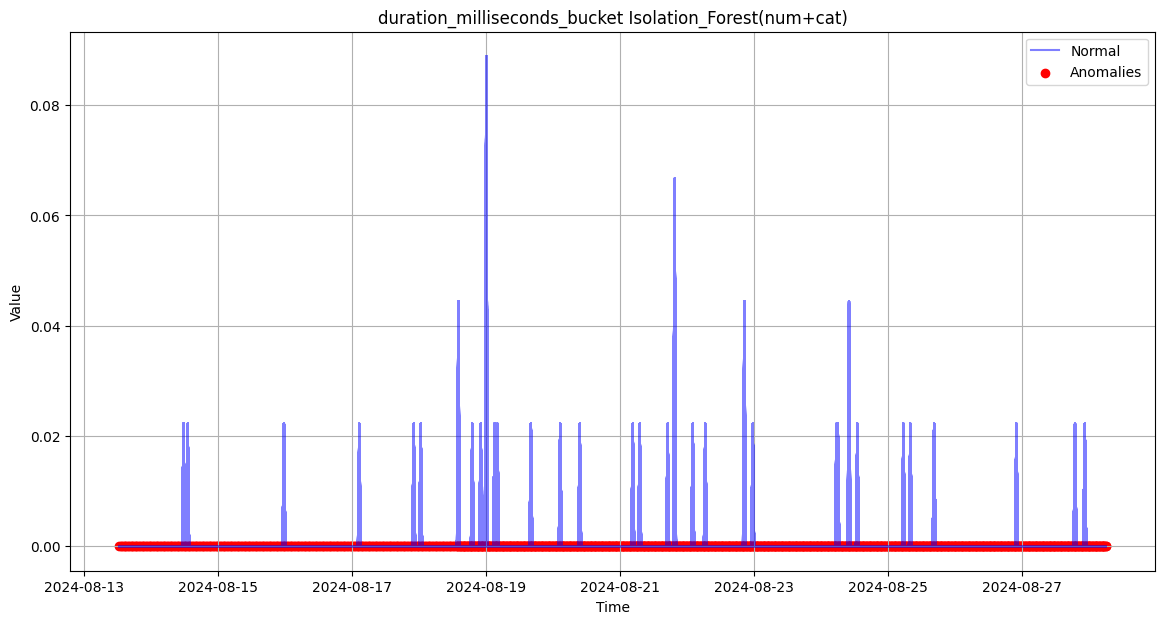

Number of anomalies detected: 1173
                      Time  Value                     exported_instance  \
772242 2024-08-18 14:00:00    0.0  4e7184d9-e546-45dc-bed1-15904d41e452   
772243 2024-08-18 14:30:00    0.0  4e7184d9-e546-45dc-bed1-15904d41e452   
772244 2024-08-18 15:00:00    0.0  4e7184d9-e546-45dc-bed1-15904d41e452   
772245 2024-08-18 15:30:00    0.0  4e7184d9-e546-45dc-bed1-15904d41e452   
772246 2024-08-18 16:00:00    0.0  4e7184d9-e546-45dc-bed1-15904d41e452   

       exported_job http_method http_route  http_status_code  \
772242         ob-1     CONNECT          /        471.667691   
772243         ob-1     CONNECT          /        471.692698   
772244         ob-1     CONNECT          /        471.717704   
772245         ob-1     CONNECT          /        471.742710   
772246         ob-1     CONNECT          /        471.767716   

                   instance                       job   le service_name  \
772242  otel-collector:8889  aggregated-trace-metrics 

In [ ]:
#model with numerical and categorical anomalies (isolation_forest)

#DATA PROCESSING-----------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from scipy.sparse import csr_matrix

# Selecting the numerical and categorical columns
numerical_columns = ['Value', 'http_status_code']
categorical_columns = ['exported_instance', 'exported_job', 'http_method',
                       'http_route', 'instance', 'job', 'service_name',
                       'span_kind', 'span_name', 'status_code']

# Preprocessing: Scaling numerical data and encoding categorical data
# Change sparse_output to False in OneHotEncoder
# or convert to CSR format after OneHotEncoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)])

# Creating the Isolation Forest model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', IsolationForest(contamination=0.001, random_state=42))])

# Fit the model
# The entire pipeline (including the ColumnTransformer) is fitted in one step
model.fit(final_df)

# Predict anomalies (anomalies will be labeled as -1, normal as 1)
final_df['anomaly'] = model.predict(final_df)

# Filter the anomalies
anomalies = final_df[final_df['anomaly'] == -1]

# Display the detected anomalies
anomalies

# PLOT THE ANOMALY
import matplotlib.pyplot as plt

# Convert 'Time' to datetime format
final_df['Time'] = pd.to_datetime(final_df['Time'])

# Plotting the time series data with anomalies
plt.figure(figsize=(14, 7))

# Plot all data points
plt.plot(final_df['Time'], final_df['Value'], label='Normal', color='blue', alpha=0.5)

# Highlight the anomalies
anomalies = final_df[final_df['anomaly'] == -1]
plt.scatter(anomalies['Time'], anomalies['Value'], color='red', label='Anomalies')

# Adding labels and title
plt.title('duration_milliseconds_bucket Isolation_Forest(num+cat)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.grid(True)
plt.show()
print(f"Number of anomalies detected: {len(anomalies)}")
print(anomalies.head())

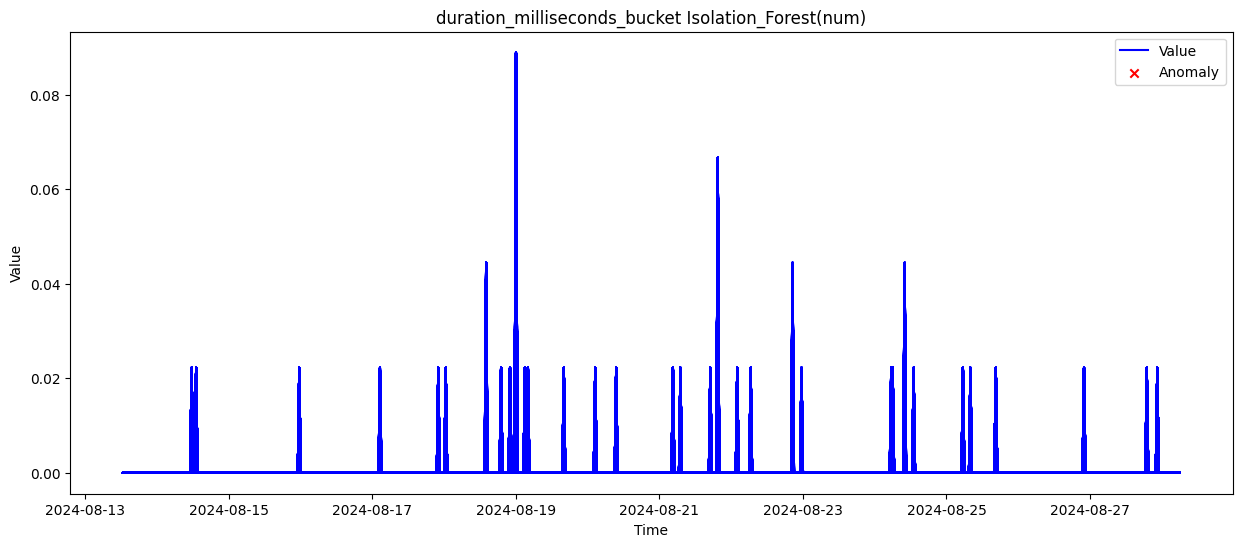

Number of anomalies detected: 0
Empty DataFrame
Columns: [Value, exported_instance, exported_job, http_method, http_route, http_status_code, instance, job, le, service_name, span_kind, span_name, status_code, anomaly]
Index: []


In [ ]:
#model with only numerical anomalies (isolation_forest)

# Convert 'Time' column to datetime and set as index
final_df['Time'] = pd.to_datetime(final_df['Time'])
final_df.set_index('Time', inplace=True)

# Select all relevant numeric metric columns for anomaly detection
metrics_columns = ['Value']  # Add other metric columns as needed
metrics_data = final_df[metrics_columns]

# Standardize the data
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_data)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)

# Fit the model and predict anomalies (-1 means anomaly, 1 means normal)
final_df['anomaly'] = iso_forest.fit_predict(metrics_scaled)

# Visualize the anomalies for each metric
for column in metrics_columns:
    plt.figure(figsize=(15, 6))
    plt.plot(final_df.index, final_df[column], label=column, color='blue')
    plt.scatter(final_df.index[final_df['anomaly'] == -1], final_df[column][final_df['anomaly'] == -1],
                color='red', label='Anomaly', marker='x')
    plt.title(f'duration_milliseconds_bucket Isolation_Forest(num)')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Print out the anomalies
anomalies = final_df[final_df['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")
print(anomalies.head())

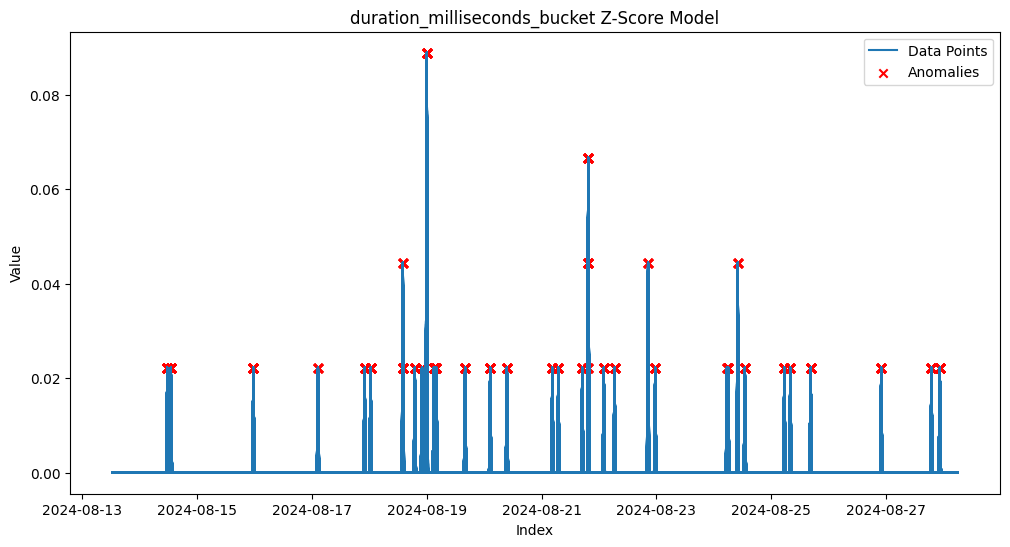

Number of anomalies detected: 1530


In [ ]:
#Z-Score
import pandas as pd
from scipy.stats import zscore

# Load your DataFrame (df) here
# df = pd.read_csv('your_file.csv')

# Compute z-scores for the "Value" column
final_df['Value_zscore'] = zscore(final_df['Value'])

# Set a threshold for anomaly detection (e.g., 3 standard deviations)
threshold =0.1

# Flag anomalies (True for anomalies, False otherwise)
final_df['Anomaly'] = (final_df['Value_zscore'].abs() > threshold)

# Display the rows with anomalies
anomalies = final_df[final_df['Anomaly']]

# Print anomalies or handle them as needed
#print(anomalies)

import matplotlib.pyplot as plt

# Set the anomaly detection threshold
#threshold = 1

# Flag anomalies (True for anomalies, False otherwise)
final_df['Anomaly'] = (final_df['Value_zscore'].abs() > threshold)

# Plotting the data points and highlighting anomalies
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Value'], label='Data Points')
plt.scatter(final_df[final_df['Anomaly']].index, final_df[final_df['Anomaly']]['Value'], color='red', label='Anomalies', marker='x')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('duration_milliseconds_bucket Z-Score Model')
plt.legend()
plt.show()
print(f"Number of anomalies detected: {len(anomalies)}")



Number of anomalies detected: 1530


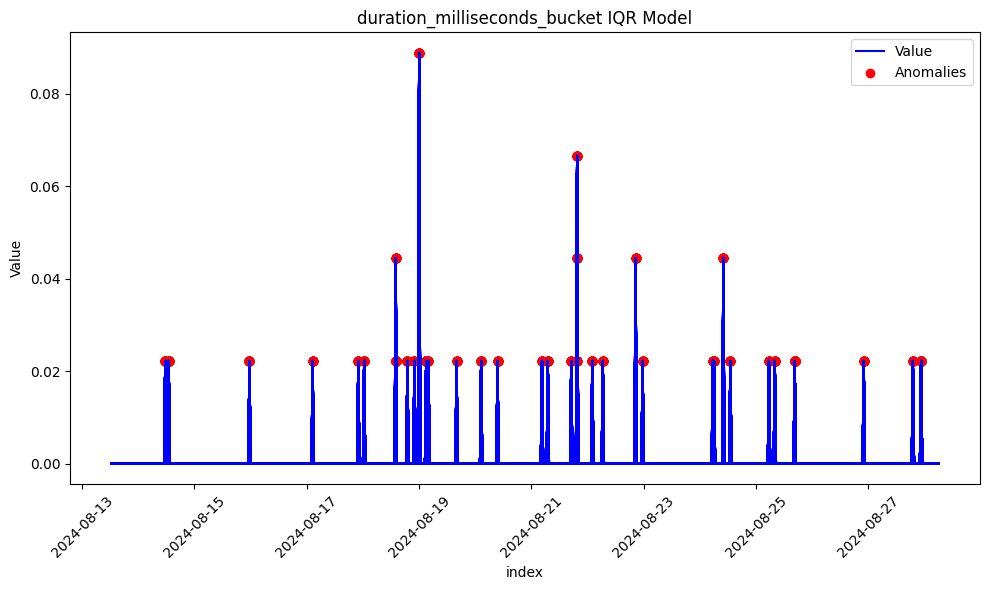

In [ ]:
#IQR

import matplotlib.pyplot as plt

# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile) for the 'Value' column
Q1 = final_df['Value'].quantile(0.25)
Q3 = final_df['Value'].quantile(0.75)

# Step 2: Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Step 3: Define the lower and upper bounds for anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Identify anomalies
anomalies = final_df[(final_df['Value'] < lower_bound) | (final_df['Value'] > upper_bound)]

print(f"Number of anomalies detected: {len(anomalies)}")

# Step 5: Plotting the graph without converting 'Time' to datetime
plt.figure(figsize=(10, 6))

# Plot all values
plt.plot(final_df.index, final_df['Value'], label='Value', color='blue')

# Highlight anomalies
plt.scatter(final_df[final_df['Anomaly']].index, final_df[final_df['Anomaly']]['Value'], color='red', label='Anomalies')

# Adding titles and labels
plt.title('duration_milliseconds_bucket IQR Model')
plt.xlabel('index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



Number of anomalies detected: 1278859


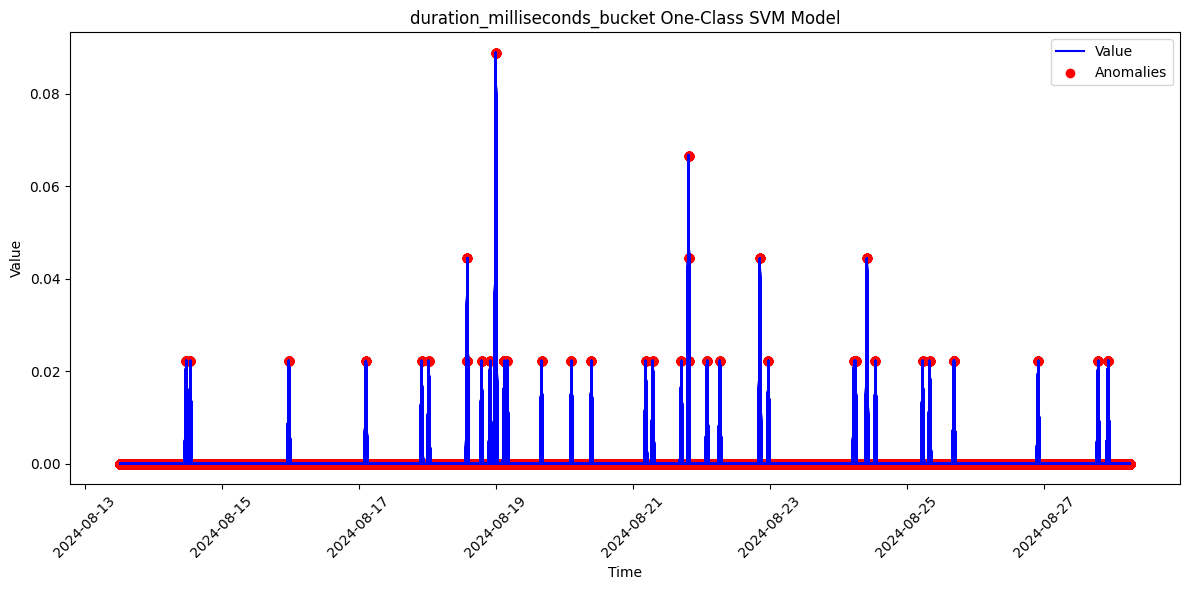

In [ ]:
#One-Class SVM Model

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
#file_path = 'C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/calls_total_df.csv'
#final_df = pd.read_csv(file_path)

# Strip any leading/trailing spaces from column names
final_df.columns = final_df.columns.str.strip()

# Select the numerical feature for One-Class SVM (e.g., 'Value')
X = final_df[['Value']]

# Standardize the feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # You can adjust the parameters based on your needs
ocsvm.fit(X_scaled)

# Predict anomalies (1 for normal, -1 for anomaly)
final_df['anomaly'] = ocsvm.predict(X_scaled)

# Display the first few rows with the anomaly column
#final_df[['Value', 'anomaly']].head()

# Convert the 'Time' column to datetime format if not already
# final_df['Time'] = pd.to_datetime(final_df['Time'])

# Plot the values over time
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Value'], label='Value', color='blue')

# Highlight anomalies
anomalies = final_df[final_df['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['Value'], color='red', label='Anomalies')

print(f"Number of anomalies detected: {len(anomalies)}")

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('duration_milliseconds_bucket One-Class SVM Model')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# LOF Model

from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

# Load the dataset
#df = pd.read_csv('your_dataset.csv')  # Use the correct path to your CSV

# Extract the 'Value' column for LOF analysis
X = final_df[['Value']].values

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust parameters as needed
final_df['LOF_Score'] = lof.fit_predict(X)

# Add a column to indicate if a point is an outlier (-1) or not (1)
final_df['Outlier'] = final_df['LOF_Score'] == -1

# Display the dataframe with LOF scores and outlier labels
print(final_df[['Time', 'Value', 'LOF_Score', 'Outlier']].head())

import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Value'], label='Value', color='blue',  alpha=0.6)

# Highlight anomalies
anomalies = final_df[final_df['Outlier'] == True]
plt.scatter(anomalies.index, anomalies['Value'], color='red', label='Anomalies')

print(f"Number of anomalies detected: {len(anomalies)}")

# Adding labels and title
plt.title('duration_milliseconds_bucket (LOF) Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.show()

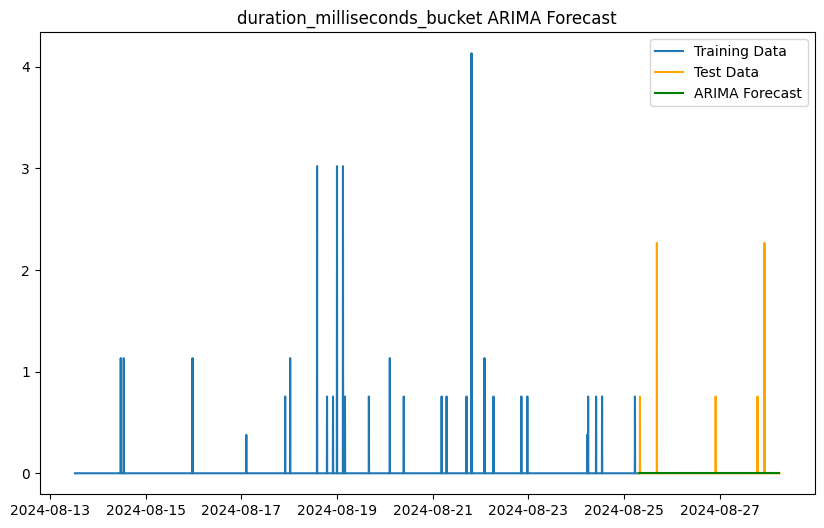

In [ ]:
#ARIMA Model

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
# file_path = 'C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/calls_total_df.csv'
# df = pd.read_csv(file_path)

# Step 2: Parse the 'Time' column as datetime and set it as the index
final_df['Time'] = pd.to_datetime(final_df['Time'])
final_df.set_index('Time', inplace=True)

# Step 3: Resample the data by summing the 'Value' column every 15 minutes to handle any irregular intervals
df_resampled = final_df['Value'].resample('5T').sum()

# Step 4: Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled[:train_size], df_resampled[train_size:]

# Step 5: Fit the ARIMA model on the training data
# We'll use a basic ARIMA model with (p, d, q) = (1, 1, 1) as a starting point.
model = ARIMA(train, order=(0, 1, 0))
arima_result = model.fit()

# Step 6: Forecast on the test data
forecast = arima_result.forecast(steps=len(test))

# Step 7: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.legend()
plt.title('duration_milliseconds_bucket ARIMA Forecast')
plt.show()


In [ ]:
#Prophet Model

<ipython-input-11-1de4651736ae>:12: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


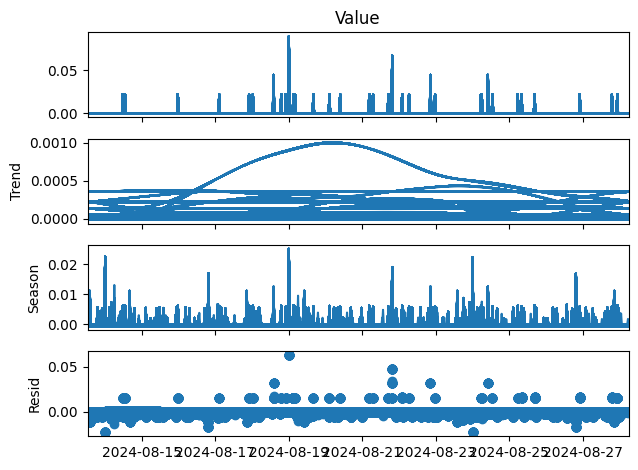

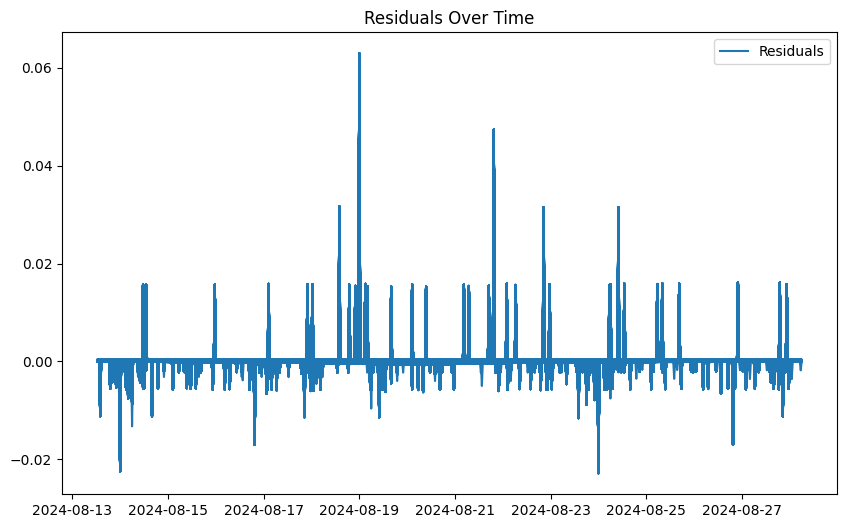

In [ ]:
#Seasonal Decomposition of Time Series (STL)

import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load the dataset
file_path = '/content/duration_milliseconds_bucket.csv'
df = pd.read_csv(file_path)
# df = final_df

# Convert 'Time' column to datetime and set it as the index
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

# Assuming data points are collected every 15 seconds in a 1-hour period
period = 240  # 4 data points per minute * 60 minutes = 240 data points per hour

# Perform STL decomposition with the specified period
stl = STL(df['Value'], period=period)
result = stl.fit()

# Plot the decomposed components
result.plot()
plt.show()

# Extract residuals from STL decomposition
residuals = result.resid

# 1. Plot the residuals over time
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

# 2. Histogram and KDE plot of residuals
# plt.figure(figsize=(10, 6))
# sns.histplot(residuals, kde=True, stat="density", linewidth=0)
# plt.title('Histogram and KDE of Residuals')
# plt.show()

# # 3. ACF and PACF plots of residuals
# plt.figure(figsize=(10, 6))
# plot_acf(residuals.dropna(), lags=40)
# plt.title('Autocorrelation Function (ACF) of Residuals')
# plt.show()

# plt.figure(figsize=(10, 6))
# plot_pacf(residuals.dropna(), lags=40)
# plt.title('Partial Autocorrelation Function (PACF) of Residuals')
# plt.show()

# # 4. Perform Augmented Dickey-Fuller test for stationarity
# adf_result = adfuller(residuals.dropna())

# # Extracting and displaying ADF test results
# adf_output = {
#     'ADF Statistic': adf_result[0],
#     'p-value': adf_result[1],
#     'Number of Lags Used': adf_result[2],
#     'Number of Observations Used': adf_result[3]
# }

# adf_output



<ipython-input-9-f84214ece1d3>:10: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Epoch 1/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 402s 39ms/step - loss: 1.4859e-04 - val_loss: 6.6772e-05
Epoch 2/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 408s 40ms/step - loss: 1.4026e-04 - val_loss: 6.6548e-05
Epoch 3/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 429s 39ms/step - loss: 1.2683e-04 - val_loss: 7.2342e-05
Epoch 4/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 442s 39ms/step - loss: 1.2408e-04 - val_loss: 6.6176e-05
Epoch 5/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 451s 40ms/step - loss: 1.4677e-04 - val_loss: 6.4590e-05
Epoch 6/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 397s 39ms/step - loss: 1.3476e-04 - val_loss: 6.5414e-05
Epoch 7/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 405s 40ms/step - loss: 1.3580e-04 - val_loss: 6.6657e-05
Epoch 8/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 445s 40ms/step - loss: 1.4389e-04 - val_loss: 6.5413e-05
Epoch 9/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 438s 40ms/step - loss: 1.3669e-04 - val_loss: 6.4972e-05
Epoch 10/10
10231/10231 ━━━━━━━━━━━━━━━━━━━━ 442s 40ms/step - loss: 1.3880e-04 - val_loss: 

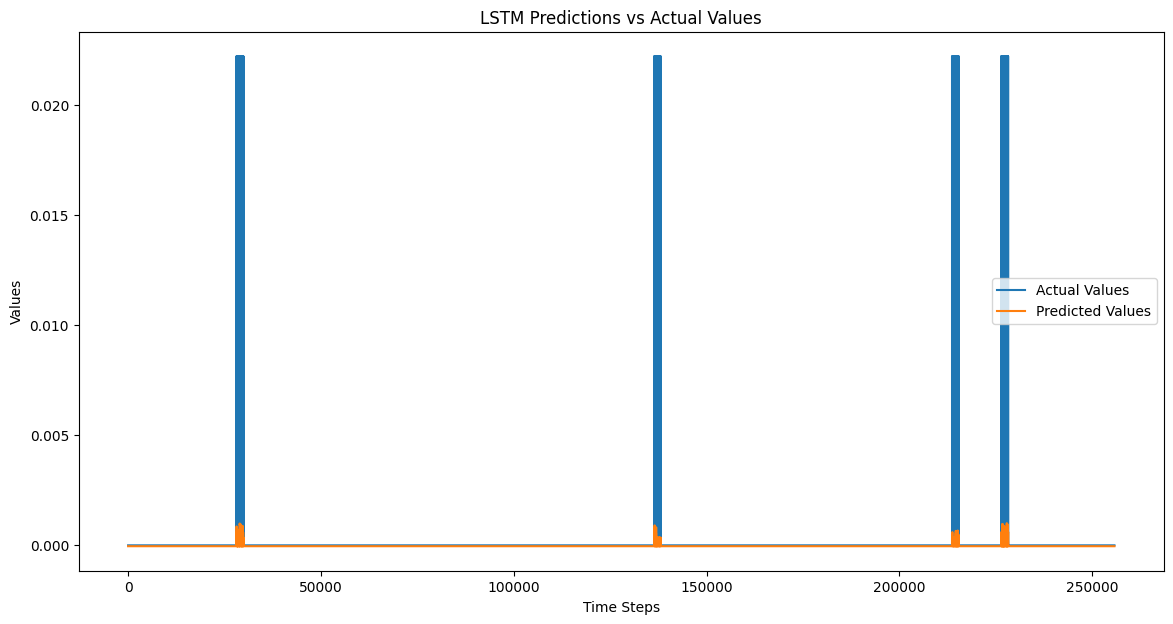

In [ ]:
#LSTM Model
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split

# Load the data
file_path = '/content/duration_milliseconds_bucket.csv'
df = pd.read_csv(file_path)

# No conversion of 'Time' column
# df['Time'] = pd.to_datetime(df['Time'])  # This line is commented out

# Sort by 'Time' (assuming you want to keep the sorting by the original format)
df = df.sort_values(by='Time')

# Extract the 'Value' column for modeling
values = df['Value'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Parameters
SEQ_LENGTH = 20  # Sequence length (this can be tuned)

# Create sequences
X, y = create_sequences(values_scaled, SEQ_LENGTH)

# Reshape X to be compatible with LSTM (samples, time steps, features)
X = np.array(X).reshape((X.shape[0], X.shape[1], 1))

# Ensure y is also a numpy array
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model with Input layer
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, 1)))  # Use Input layer to define the shape
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get them back to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Print a few predictions and actual values
print("Predictions:", predictions_rescaled[:5].flatten())
print("Actual Values:", y_test_rescaled[:5].flatten())

# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Values')
plt.plot(predictions_rescaled, label='Predicted Values')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()


<ipython-input-4-b2d5ecaaef85>:12: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/duration_milliseconds_bucket.csv')


Epoch 1/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0559 - val_loss: 0.0487
Epoch 2/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0470 - val_loss: 0.0487
Epoch 3/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0471 - val_loss: 0.0487
Epoch 4/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0452 - val_loss: 0.0487
Epoch 5/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0487 - val_loss: 0.0487
Epoch 6/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 0.0468 - val_loss: 0.0487
Epoch 7/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0483 - val_loss: 0.0487
Epoch 8/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0468 - val_loss: 0.0487
Epoch 9/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.0455 - val_loss: 0.0487
Epoch 10/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.0466 - val_loss: 0.0487
Epoch 11/20
3997/3997 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0482 - val_loss: 0.0487
Epoch 12/20
3997/39

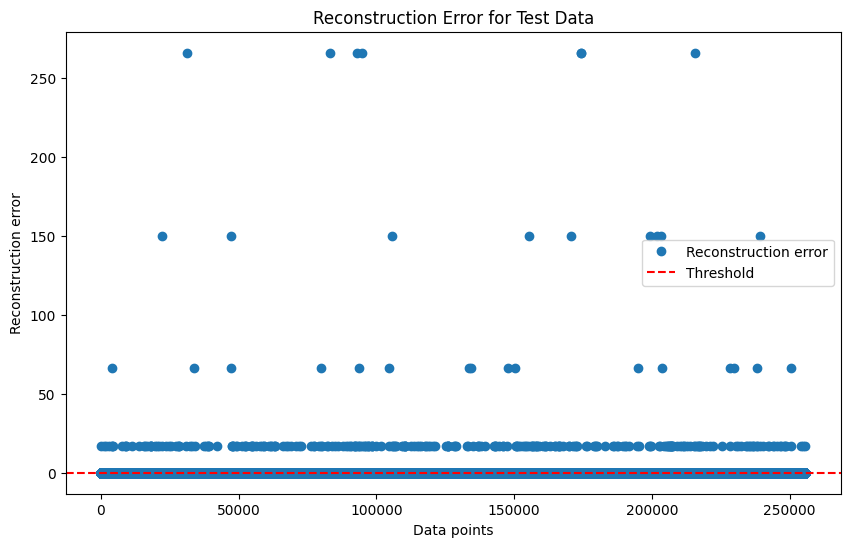

Number of anomalies detected: 11537


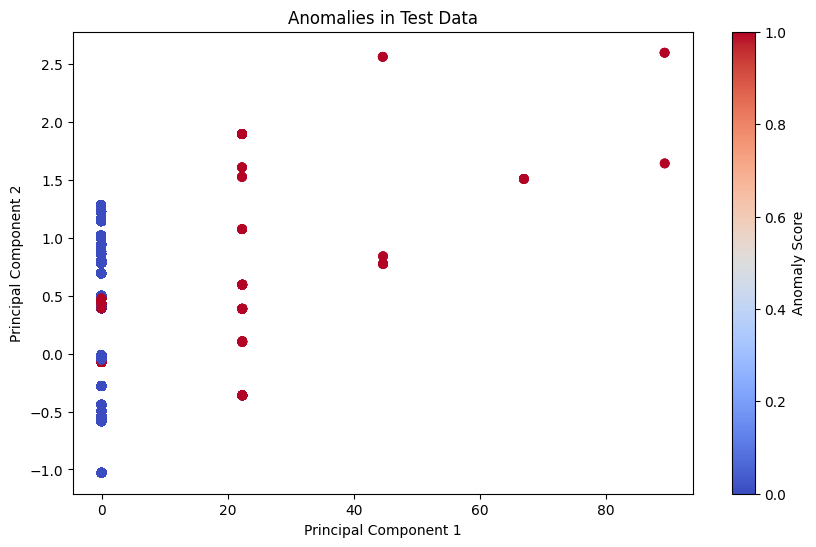

In [4]:
#Autoencoder Model[check google collab folder for results]

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models # Changed the import statement to import layers from tensorflow.keras

# Load your data
df = pd.read_csv('/content/duration_milliseconds_bucket.csv')

# Preprocessing
numerical_features = ['Value']
categorical_features = ['http_method', 'http_route', 'http_status_code']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X = df[numerical_features + categorical_features]
X_preprocessed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test = train_test_split(X_preprocessed, test_size=0.2, random_state=42)

# Convert sparse to dense arrays if needed
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Autoencoder model
input_dim = X_train_dense.shape[1]
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(X_train_dense, X_train_dense,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_dense, X_test_dense))

import matplotlib.pyplot as plt

# Predict the reconstructed output for the test set
X_test_pred = autoencoder.predict(X_test_dense)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.power(X_test_dense - X_test_pred, 2), axis=1)

# Define a threshold for an anomaly (can be adjusted)
threshold = np.percentile(reconstruction_error, 95)  # Adjust percentile as needed

# Identify anomalies
anomalies = reconstruction_error > threshold

# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, marker='o', linestyle='none', label='Reconstruction error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Data points')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction Error for Test Data')
plt.legend()
plt.show()

# (Optional) Print the number of anomalies found
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# (Optional) Visualize the anomalies - if you have low-dimensional data or can reduce the dimension
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_dense)

plt.figure(figsize=(10, 6))
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=anomalies, cmap='coolwarm')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Anomalies in Test Data')
plt.colorbar(label='Anomaly Score')
plt.show()


